In [1]:
#import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandasql import sqldf #import sql from panda
pysqldf = lambda q: sqldf(q, globals()) #lambada function to pass query

In [12]:
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
#import data
fd = pd.read_csv("/Users/ifeanyichukwumichaelifiegbu/Desktop/SHU_THESIS/PayGap/Data/cleaned_gpg_data.csv")

In [3]:
fd1 = fd.copy()

In [4]:
fd1

,gender,annual_salary_amount_in_usd,job_experience,job_pay_level,full_or_part_time,hourly_or_salary,job_family_group,job_continent
0,Female,45000.00,2,Second Year Associate,Full time,Salary,Client Strategy,Americas
1,Male,41644.08,9,Team Lead,Full time,Salary,Catering,Oceania
2,Female,42134.82,5,Junior Associate,Full time,Salary,Client Strategy,Europe
3,Female,43667.64,6,Team Lead,Full time,Salary,Catering,Asia
4,Female,63750.00,7,Senior Associate,Full time,Salary,Graphic Design,Americas
...,...,...,...,...,...,...,...,...
1915,Male,48000.00,5,Junior Associate,Full time,Salary,Catering,Americas
1916,Male,75000.00,5,Junior Associate,Full time,Salary,Investment,Americas
1917,Female,26520.00,1,Second Year Associate,Full time,Hourly,Catering,Americas
1918,Female,29561.68,11,Senior Associate,Full time,Salary,Expansion,Americas


In [7]:
#group data by job family group
grouped = fd1.groupby("job_family_group")


In [8]:
dfs = {group: data for group, data in grouped} #dictionary of all groups

In [23]:
# check dictionary
dfs['Catering']

,gender,annual_salary_amount_in_usd,job_experience,job_pay_level,full_or_part_time,hourly_or_salary,job_family_group,job_continent
1,Male,41644.08,9,Team Lead,Full time,Salary,Catering,Oceania
3,Female,43667.64,6,Team Lead,Full time,Salary,Catering,Asia
6,Male,49500.00,2,Junior Associate,Full time,Salary,Catering,Americas
10,Male,45880.13,6,Junior Associate,Full time,Salary,Catering,Europe
18,Male,50700.00,3,Junior Associate,Full time,Hourly,Catering,Americas
...,...,...,...,...,...,...,...,...
1909,Female,34540.10,8,Junior Associate,Full time,Salary,Catering,Europe
1914,Female,48750.00,2,Second Year Associate,Full time,Salary,Catering,Americas
1915,Male,48000.00,5,Junior Associate,Full time,Salary,Catering,Americas
1917,Female,26520.00,1,Second Year Associate,Full time,Hourly,Catering,Americas


In [11]:
keys = [i for i in dfs.keys()]

keys

['Catering',
 'Client Strategy',
 'Client Techology',
 'Customer Experience',
 'Expansion',
 'Government Consulting',
 'Graphic Design',
 'IPO Strategy',
 'Investment',
 'Leadership',
 'Patent Law',
 'Pricing Analytics',
 'R&D',
 'Research',
 'Strategy',
 'Technology Services']

In [13]:

# Function to one-hot encode and calculate variance
def process_df(df):
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Fit OLS regression and calculate variance
    X = df_encoded.drop('annual_salary_amount_in_usd', axis=1)  # Assuming 'column_4' is the dependent variable
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(df['annual_salary_amount_in_usd'], X).fit()
    residuals_variance = model.resid.var()
    
    small_number = 0.0015

    # Add weight column
    df_encoded['weight'] = 1 / (residuals_variance + small_number)

    return df_encoded

In [14]:
# Apply the function to each DataFrame in the dictionary
processed_dfs = {k: process_df(v) for k, v in dfs.items()}

/Users/ifeanyichukwumichaelifiegbu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
# check dictionary
processed_dfs['Catering']['weight'].unique()

array([1.00506686e-08])

In [29]:
# Extract the unique weight for each DataFrame
weights = {key: df['weight'].iloc[0] for key, df in processed_dfs.items()}

# Convert the dictionary to a DataFrame
weights_df = pd.DataFrame(list(weights.items()), columns=['Name', 'Unique Weight'])

weights_df

,Name,Unique Weight
0,Catering,1.005067e-08
1,Client Strategy,2.920726e-09
2,Client Techology,2.055535e-09
3,Customer Experience,2.930875e-09
4,Expansion,2.219937e-09
5,Government Consulting,1.411990e-08
6,Graphic Design,8.649861e-10
7,IPO Strategy,1.005992e-08
8,Investment,5.610108e-09
9,Leadership,8.994134e-11


In [32]:
fd2 = fd1.copy() #copy original dataframe

In [33]:
# map weights to original dataframe
fd2["weight"] = fd2["job_family_group"].map(weights)

In [34]:
fd2

,gender,annual_salary_amount_in_usd,job_experience,job_pay_level,full_or_part_time,hourly_or_salary,job_family_group,job_continent,weight
0,Female,45000.00,2,Second Year Associate,Full time,Salary,Client Strategy,Americas,2.920726e-09
1,Male,41644.08,9,Team Lead,Full time,Salary,Catering,Oceania,1.005067e-08
2,Female,42134.82,5,Junior Associate,Full time,Salary,Client Strategy,Europe,2.920726e-09
3,Female,43667.64,6,Team Lead,Full time,Salary,Catering,Asia,1.005067e-08
4,Female,63750.00,7,Senior Associate,Full time,Salary,Graphic Design,Americas,8.649861e-10
...,...,...,...,...,...,...,...,...,...
1915,Male,48000.00,5,Junior Associate,Full time,Salary,Catering,Americas,1.005067e-08
1916,Male,75000.00,5,Junior Associate,Full time,Salary,Investment,Americas,5.610108e-09
1917,Female,26520.00,1,Second Year Associate,Full time,Hourly,Catering,Americas,1.005067e-08
1918,Female,29561.68,11,Senior Associate,Full time,Salary,Expansion,Americas,2.219937e-09


In [45]:
# assign y, X, and weight
y = fd2['annual_salary_amount_in_usd'] # dependent variable
group_weight = fd2['weight']  #weights of from ols model fit
X = fd2[["gender", "job_experience", "job_pay_level", "full_or_part_time", "hourly_or_salary", "job_family_group", "job_continent"]]

In [46]:
# One-hot encode categorical independent variables
X = pd.get_dummies(X, drop_first=True)

X

,job_experience,gender_Male,job_pay_level_Director II,job_pay_level_Entry Level,job_pay_level_Junior Associate,job_pay_level_Manager,job_pay_level_Manger II,job_pay_level_Partner,job_pay_level_Second Year Associate,job_pay_level_Senior Associate,...,job_family_group_Patent Law,job_family_group_Pricing Analytics,job_family_group_R&D,job_family_group_Research,job_family_group_Strategy,job_family_group_Technology Services,job_continent_Americas,job_continent_Asia,job_continent_Europe,job_continent_Oceania
0,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,7,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,5,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1916,5,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1917,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1918,11,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [47]:
X = sm.add_constant(X)  # Adds a constant term to the predictor

/Users/ifeanyichukwumichaelifiegbu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
# Fit OLS regression and calculate variance
ols_model = sm.OLS(y, X).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     annual_salary_amount_in_usd   R-squared:                       0.809
Model:                                     OLS   Adj. R-squared:                  0.806
Method:                          Least Squares   F-statistic:                     234.8
Date:                         Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                                 12:29:40   Log-Likelihood:                -22121.
No. Observations:                         1920   AIC:                         4.431e+04
Df Residuals:                             1885   BIC:                         4.451e+04
Df Model:                                   34                                         
Covariance Type:                     nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   1.556e+05   1.53e+04     10.161      0.000    1.26e+05    1.86e+05
job_experience                           526.2002     96.604      5.447      0.000     336.737     715.663
gender_Male                             2577.4757   1201.327      2.146      0.032     221.405    4933.546
job_pay_level_Director II                8.34e+04   1.07e+04      7.793      0.000    6.24e+04    1.04e+05
job_pay_level_Entry Level              -1.753e+05   5151.144    -34.034      0.000   -1.85e+05   -1.65e+05
job_pay_level_Junior Associate         -1.605e+05   4464.657    -35.959      0.000   -1.69e+05   -1.52e+05
job_pay_level_Manager                  -1.117e+05   4607.333    -24.238      0.000   -1.21e+05   -1.03e+05
job_pay_level_Manger II                -9.307e+04   4739.541    -19.638      0.000   -1.02e+05   -8.38e+04
job_pay_level_Partner                  -9.797e+04   1.97e+04     -4.981      0.000   -1.37e+05   -5.94e+04
job_pay_level_Second Year Associate    -1.685e+05   4879.385    -34.529      0.000   -1.78e+05   -1.59e+05
job_pay_level_Senior Associate         -1.516e+05   4473.070    -33.896      0.000    -1.6e+05   -1.43e+05
job_pay_level_Sr Manager               -5.775e+04   5235.028    -11.031      0.000    -6.8e+04   -4.75e+04
job_pay_level_Team Lead                -1.365e+05   4425.454    -30.847      0.000   -1.45e+05   -1.28e+05
job_pay_level_VP                        2.614e+05    1.5e+04     17.470      0.000    2.32e+05    2.91e+05
full_or_part_time_Part time            -1.636e+04   6615.229     -2.473      0.014   -2.93e+04   -3382.926
hourly_or_salary_Salary                -1606.6570   2790.117     -0.576      0.565   -7078.699    3865.385
job_family_group_Client Strategy        1.184e+04   2188.548      5.412      0.000    7551.876    1.61e+04
job_family_group_Client Techology       1.869e+04   3922.861      4.765      0.000     1.1e+04    2.64e+04
job_family_group_Customer Experience    1.549e+04   2423.753      6.390      0.000    1.07e+04    2.02e+04
job_family_group_Expansion              1.818e+04   2608.543      6.971      0.000    1.31e+04    2.33e+04
job_family_group_Government Consulting  6516.4595   3596.579      1.812      0.070    -537.235    1.36e+04
job_family_group_Graphic Design         2.067e+04   3596.060      5.749      0.000    1.36e+04    2.77e+04
job_family_group_IPO Strategy           1.255e+04   6837.846      1.835      0.067    -862.387     2.6e+04
job_family_group_Investment             2.334e+04   3040.801      7.676      0.000    1.74e+04    2.93e+04
job_family_group_Leadership             4.355e+04   9191.583      4.738      0.000    2.55e+04 

In [49]:
# Fit WLS regression 
wls_model = sm.WLS(y, X, weights=group_weight).fit()

wls_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:     annual_salary_amount_in_usd   R-squared:                       0.851
Model:                                     WLS   Adj. R-squared:                  0.848
Method:                          Least Squares   F-statistic:                     315.5
Date:                         Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                                 12:30:03   Log-Likelihood:                -21624.
No. Observations:                         1920   AIC:                         4.332e+04
Df Residuals:                             1885   BIC:                         4.351e+04
Df Model:                                   34                                         
Covariance Type:                     nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   1.616e+05   9171.007     17.620      0.000    1.44e+05     1.8e+05
job_experience                           162.0073     60.208      2.691      0.007      43.926     280.088
gender_Male                             1381.5916    801.990      1.723      0.085    -191.291    2954.474
job_pay_level_Director II               2.333e+04   1.49e+04      1.566      0.117   -5887.592    5.26e+04
job_pay_level_Entry Level              -1.729e+05   4071.729    -42.474      0.000   -1.81e+05   -1.65e+05
job_pay_level_Junior Associate         -1.551e+05   3783.265    -41.004      0.000   -1.63e+05   -1.48e+05
job_pay_level_Manager                  -1.094e+05   3933.517    -27.819      0.000   -1.17e+05   -1.02e+05
job_pay_level_Manger II                -9.524e+04   4050.256    -23.514      0.000   -1.03e+05   -8.73e+04
job_pay_level_Partner                    -1.2e+05   9.78e+04     -1.227      0.220   -3.12e+05    7.18e+04
job_pay_level_Second Year Associate    -1.639e+05   4049.589    -40.469      0.000   -1.72e+05   -1.56e+05
job_pay_level_Senior Associate         -1.482e+05   3844.333    -38.541      0.000   -1.56e+05   -1.41e+05
job_pay_level_Sr Manager               -5.208e+04   4360.090    -11.946      0.000   -6.06e+04   -4.35e+04
job_pay_level_Team Lead                -1.339e+05   3778.744    -35.430      0.000   -1.41e+05   -1.26e+05
job_pay_level_VP                        2.302e+05   1.31e+04     17.569      0.000    2.04e+05    2.56e+05
full_or_part_time_Part time            -1.573e+04   2951.138     -5.329      0.000   -2.15e+04   -9939.163
hourly_or_salary_Salary                -2603.5617   1643.890     -1.584      0.113   -5827.597     620.474
job_family_group_Client Strategy        1.486e+04   1650.155      9.005      0.000    1.16e+04    1.81e+04
job_family_group_Client Techology        2.08e+04   3969.558      5.239      0.000     1.3e+04    2.86e+04
job_family_group_Customer Experience    1.755e+04   1901.297      9.229      0.000    1.38e+04    2.13e+04
job_family_group_Expansion              2.232e+04   2318.205      9.628      0.000    1.78e+04    2.69e+04
job_family_group_Government Consulting  9489.3068   1576.559      6.019      0.000    6397.322    1.26e+04
job_family_group_Graphic Design         2.491e+04   5448.686      4.571      0.000    1.42e+04    3.56e+04
job_family_group_IPO Strategy           1.501e+04   3419.724      4.390      0.000    8306.906    2.17e+04
job_family_group_Investment             2.664e+04   1912.371     13.930      0.000    2.29e+04    3.04e+04
job_family_group_Leadership             7.975e+04   3.89e+04      2.052      0.040    3521.326 

In [70]:
fd3 = fd2.copy() #copy fd2

In [113]:
fd3

,gender,annual_salary_amount_in_usd,job_experience,job_pay_level,full_or_part_time,hourly_or_salary,job_family_group,job_continent,weight
0,Female,45000.00,2,Second Year Associate,Full time,Salary,Client Strategy,Americas,2.920726e-09
1,Male,41644.08,9,Team Lead,Full time,Salary,Catering,Oceania,1.005067e-08
2,Female,42134.82,5,Junior Associate,Full time,Salary,Client Strategy,Europe,2.920726e-09
3,Female,43667.64,6,Team Lead,Full time,Salary,Catering,Asia,1.005067e-08
4,Female,63750.00,7,Senior Associate,Full time,Salary,Graphic Design,Americas,8.649861e-10
...,...,...,...,...,...,...,...,...,...
1915,Male,48000.00,5,Junior Associate,Full time,Salary,Catering,Americas,1.005067e-08
1916,Male,75000.00,5,Junior Associate,Full time,Salary,Investment,Americas,5.610108e-09
1917,Female,26520.00,1,Second Year Associate,Full time,Hourly,Catering,Americas,1.005067e-08
1918,Female,29561.68,11,Senior Associate,Full time,Salary,Expansion,Americas,2.219937e-09


In [114]:
fd3_encoded = pd.get_dummies(fd3, drop_first=True) #encode dataframe

fd3_encoded

,annual_salary_amount_in_usd,job_experience,weight,gender_Male,job_pay_level_Director II,job_pay_level_Entry Level,job_pay_level_Junior Associate,job_pay_level_Manager,job_pay_level_Manger II,job_pay_level_Partner,...,job_family_group_Patent Law,job_family_group_Pricing Analytics,job_family_group_R&D,job_family_group_Research,job_family_group_Strategy,job_family_group_Technology Services,job_continent_Americas,job_continent_Asia,job_continent_Europe,job_continent_Oceania
0,45000.00,2,2.920726e-09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,41644.08,9,1.005067e-08,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,42134.82,5,2.920726e-09,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,43667.64,6,1.005067e-08,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,63750.00,7,8.649861e-10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,48000.00,5,1.005067e-08,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1916,75000.00,5,5.610108e-09,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1917,26520.00,1,1.005067e-08,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1918,29561.68,11,2.219937e-09,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [115]:
from sklearn.model_selection import train_test_split

In [116]:
y = fd3_encoded['annual_salary_amount_in_usd']
X = fd3_encoded.drop('annual_salary_amount_in_usd', axis=1)

In [119]:
xTrain, xValid, yTrain, yValid = train_test_split(X, y, train_size=0.6, random_state=5)

In [122]:
xTrain

,job_experience,gender_Male,job_pay_level_Director II,job_pay_level_Entry Level,job_pay_level_Junior Associate,job_pay_level_Manager,job_pay_level_Manger II,job_pay_level_Partner,job_pay_level_Second Year Associate,job_pay_level_Senior Associate,...,job_family_group_Patent Law,job_family_group_Pricing Analytics,job_family_group_R&D,job_family_group_Research,job_family_group_Strategy,job_family_group_Technology Services,job_continent_Americas,job_continent_Asia,job_continent_Europe,job_continent_Oceania
1537,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1285,4,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1469,11,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1298,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1157,26,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,32,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
998,7,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1725,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
206,9,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [121]:
#get training data weights
Train_weight = xTrain['weight']
xTrain = xTrain.drop('weight', axis=1) #drop weights column

In [123]:
Validation_weight = xValid['weight']
xValid = xValid.drop('weight', axis=1)

In [124]:
from sklearn.linear_model import LinearRegression

In [125]:
lm = LinearRegression()
ols_reg = lm.fit(xTrain, yTrain)

ols_reg


LinearRegression()

In [126]:

wls_reg = lm.fit(xTrain, yTrain, Train_weight)

wls_reg

LinearRegression()

In [127]:
print("OLS Intercept: ", ols_reg.intercept_)
print("WLS Intercept: ", wls_reg.intercept_)

OLS Intercept:  163053.47003307726
WLS Intercept:  163053.47003307726


In [128]:
ols_reg.coef_

array([ 1.69043070e+02,  9.10178722e+02,  1.47804474e+05, -1.72354872e+05,
       -1.54561012e+05, -1.08683140e+05, -9.42954202e+04, -2.45523023e+04,
       -1.63377063e+05, -1.49453241e+05, -5.32122096e+04, -1.33100133e+05,
        3.48888300e+05, -1.52065852e+04, -2.11273663e+03,  1.53178020e+04,
        1.63984235e+04,  1.87653905e+04,  2.24541038e+04,  1.08601943e+04,
        1.88194722e+04,  1.82456080e+04,  2.77442705e+04, -1.56802842e+04,
        3.19741255e+04,  4.57507081e+04,  2.29614317e+04,  1.67466626e+03,
        2.45325550e+04,  6.37185044e+04,  3.07029717e+04,  9.50496895e+03,
        2.17429365e+04,  2.08840051e+04])

In [129]:
wls_reg.coef_

array([ 1.69043070e+02,  9.10178722e+02,  1.47804474e+05, -1.72354872e+05,
       -1.54561012e+05, -1.08683140e+05, -9.42954202e+04, -2.45523023e+04,
       -1.63377063e+05, -1.49453241e+05, -5.32122096e+04, -1.33100133e+05,
        3.48888300e+05, -1.52065852e+04, -2.11273663e+03,  1.53178020e+04,
        1.63984235e+04,  1.87653905e+04,  2.24541038e+04,  1.08601943e+04,
        1.88194722e+04,  1.82456080e+04,  2.77442705e+04, -1.56802842e+04,
        3.19741255e+04,  4.57507081e+04,  2.29614317e+04,  1.67466626e+03,
        2.45325550e+04,  6.37185044e+04,  3.07029717e+04,  9.50496895e+03,
        2.17429365e+04,  2.08840051e+04])

In [130]:
pd.DataFrame(list(zip(xTrain.columns, ols_reg.coef_, wls_reg.coef_)), columns=['Attributes', 'OLS Estimates', 'WLS Estimates'])

,Attributes,OLS Estimates,WLS Estimates
0,job_experience,169.043070,169.043070
1,gender_Male,910.178722,910.178722
2,job_pay_level_Director II,147804.474428,147804.474428
3,job_pay_level_Entry Level,-172354.872005,-172354.872005
4,job_pay_level_Junior Associate,-154561.012079,-154561.012079
5,job_pay_level_Manager,-108683.140077,-108683.140077
6,job_pay_level_Manger II,-94295.420237,-94295.420237
7,job_pay_level_Partner,-24552.302304,-24552.302304
8,job_pay_level_Second Year Associate,-163377.062531,-163377.062531
9,job_pay_level_Senior Associate,-149453.240734,-149453.240734


In [131]:
# from sklearn import metrics

In [139]:
ols_TrainR2 = ols_reg.score(xTrain, yTrain)
ols_ValR2 = ols_reg.score(xValid, yValid)
print("Training: ", ols_TrainR2)
print("Validation: ", ols_ValR2)

Training:  0.8349403541185765
Validation:  0.7398041290182741


In [140]:
wls_TrainR2 = wls_reg.score(xTrain, yTrain, Train_weight)
wls_ValR2 = wls_reg.score(xValid, yValid, Validation_weight)
print("Training: ", wls_TrainR2)
print("Validation: ", wls_ValR2)

Training:  0.8543781806892456
Validation:  0.8046511048422621


In [143]:
from sklearn.feature_selection import SelectKBest, f_regression

In [144]:
select = SelectKBest(k=2, score_func=f_regression)
select.fit(xTrain, yTrain)

SelectKBest(k=2, score_func=<function f_regression at 0x7fb1696a5040>)

In [145]:
select.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False])

In [147]:
list(zip(xTrain, select.get_support()))

[('job_experience', False),
 ('gender_Male', False),
 ('job_pay_level_Director II', False),
 ('job_pay_level_Entry Level', False),
 ('job_pay_level_Junior Associate', False),
 ('job_pay_level_Manager', False),
 ('job_pay_level_Manger II', False),
 ('job_pay_level_Partner', False),
 ('job_pay_level_Second Year Associate', False),
 ('job_pay_level_Senior Associate', False),
 ('job_pay_level_Sr Manager', False),
 ('job_pay_level_Team Lead', False),
 ('job_pay_level_VP', True),
 ('full_or_part_time_Part time', False),
 ('hourly_or_salary_Salary', False),
 ('job_family_group_Client Strategy', False),
 ('job_family_group_Client Techology', False),
 ('job_family_group_Customer Experience', False),
 ('job_family_group_Expansion', False),
 ('job_family_group_Government Consulting', False),
 ('job_family_group_Graphic Design', False),
 ('job_family_group_IPO Strategy', False),
 ('job_family_group_Investment', False),
 ('job_family_group_Leadership', False),
 ('job_family_group_Patent Law', False

In [148]:
newxTrain = select.transform(xTrain)

In [152]:
new_ols_reg = lm.fit(newxTrain, yTrain)

In [150]:
newxValid = select.transform(xValid)

In [154]:
TrainR2 = new_ols_reg.score(newxTrain, yTrain)
ValR2 = new_ols_reg.score(newxValid, yValid)
print("Training: ", TrainR2)
print("Validation: ", ValR2)

Training:  0.28320297740667544
Validation:  0.1501541027403691


In [155]:
k_range=list(range(1, 35))

In [156]:
k_score = []
for i in k_range:
    select = SelectKBest(k=i, score_func=f_regression)
    select.fit(xTrain, yTrain)
    newxTrain=select.transform(xTrain)
    model = lm.fit(newxTrain, yTrain)
    k_score.append(model.score(select.transform(xValid), yValid))
print(k_score)

[0.1265086638583487, 0.1501541027403691, 0.25176304009658146, 0.32567103967095556, 0.3617333316810515, 0.405497847152962, 0.4232247979054342, 0.43932998746714835, 0.44972273621625936, 0.4528755338566901, 0.4477482361513868, 0.4652559136244645, 0.5895205961202561, 0.5916167893510593, 0.6107318960373571, 0.6228106790540116, 0.6235915515457886, 0.6249797657846772, 0.6263670655156779, 0.626376620928117, 0.6267531230696042, 0.623877489498089, 0.6247906852466849, 0.624304912874557, 0.6249545789838005, 0.7357663238626742, 0.736544803966509, 0.7373277404678165, 0.7372484485820803, 0.7377323756663889, 0.739106210456381, 0.7428194721657473, 0.7429725858186553, 0.7470848307733344]


In [162]:
k_score.sort()

k_score[-1]

0.7470848307733344

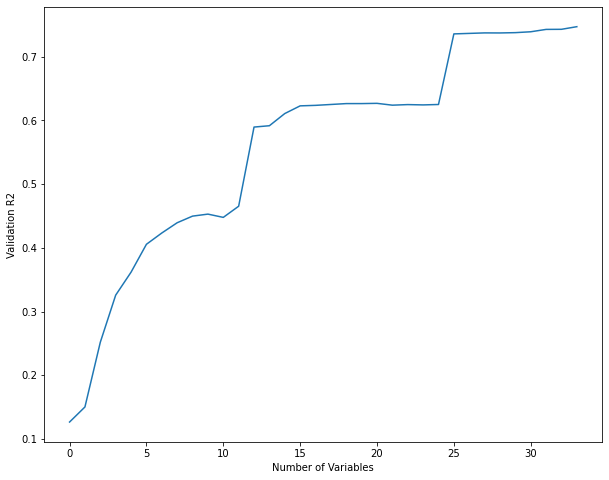

In [159]:
plt.figure(figsize=(10,8))
plt.plot(k_score)
plt.xlabel("Number of Variables")
plt.ylabel("Validation R2")
plt.show()

In [167]:
yt = fd3_encoded['annual_salary_amount_in_usd']
wt = fd3_encoded['weight']
Xt = fd3_encoded.drop(['annual_salary_amount_in_usd', 'weight'], axis=1)

In [168]:
# Assuming X and y are your independent and dependent variables
Xt = sm.add_constant(Xt)  # Adds a constant term to the predictors

#fit the OLS model
ols_model = sm.OLS(yt, Xt).fit()

# Calculate residuals
residuals = ols_model.resid

# Calculate variance of residuals
residual_variance = residuals.var()

/Users/ifeanyichukwumichaelifiegbu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [169]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     annual_salary_amount_in_usd   R-squared:                       0.809
Model:                                     OLS   Adj. R-squared:                  0.806
Method:                          Least Squares   F-statistic:                     234.8
Date:                         Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                                 14:31:17   Log-Likelihood:                -22121.
No. Observations:                         1920   AIC:                         4.431e+04
Df Residuals:                             1885   BIC:                         4.451e+04
Df Model:                                   34                                         
Covariance Type:                     nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                   1.556e+05   1.53e+04     10.161      0.000    1.26e+05    1.86e+05
job_experience                           526.2002     96.604      5.447      0.000     336.737     715.663
gender_Male                             2577.4757   1201.327      2.146      0.032     221.405    4933.546
job_pay_level_Director II                8.34e+04   1.07e+04      7.793      0.000    6.24e+04    1.04e+05
job_pay_level_Entry Level              -1.753e+05   5151.144    -34.034      0.000   -1.85e+05   -1.65e+05
job_pay_level_Junior Associate         -1.605e+05   4464.657    -35.959      0.000   -1.69e+05   -1.52e+05
job_pay_level_Manager                  -1.117e+05   4607.333    -24.238      0.000   -1.21e+05   -1.03e+05
job_pay_level_Manger II                -9.307e+04   4739.541    -19.638      0.000   -1.02e+05   -8.38e+04
job_pay_level_Partner                  -9.797e+04   1.97e+04     -4.981      0.000   -1.37e+05   -5.94e+04
job_pay_level_Second Year Associate    -1.685e+05   4879.385    -34.529      0.000   -1.78e+05   -1.59e+05
job_pay_level_Senior Associate         -1.516e+05   4473.070    -33.896      0.000    -1.6e+05   -1.43e+05
job_pay_level_Sr Manager               -5.775e+04   5235.028    -11.031      0.000    -6.8e+04   -4.75e+04
job_pay_level_Team Lead                -1.365e+05   4425.454    -30.847      0.000   -1.45e+05   -1.28e+05
job_pay_level_VP                        2.614e+05    1.5e+04     17.470      0.000    2.32e+05    2.91e+05
full_or_part_time_Part time            -1.636e+04   6615.229     -2.473      0.014   -2.93e+04   -3382.926
hourly_or_salary_Salary                -1606.6570   2790.117     -0.576      0.565   -7078.699    3865.385
job_family_group_Client Strategy        1.184e+04   2188.548      5.412      0.000    7551.876    1.61e+04
job_family_group_Client Techology       1.869e+04   3922.861      4.765      0.000     1.1e+04    2.64e+04
job_family_group_Customer Experience    1.549e+04   2423.753      6.390      0.000    1.07e+04    2.02e+04
job_family_group_Expansion              1.818e+04   2608.543      6.971      0.000    1.31e+04    2.33e+04
job_family_group_Government Consulting  6516.4595   3596.579      1.812      0.070    -537.235    1.36e+04
job_family_group_Graphic Design         2.067e+04   3596.060      5.749      0.000    1.36e+04    2.77e+04
job_family_group_IPO Strategy           1.255e+04   6837.846      1.835      0.067    -862.387     2.6e+04
job_family_group_Investment             2.334e+04   3040.801      7.676      0.000    1.74e+04    2.93e+04
job_family_group_Leadership             4.355e+04   9191.583      4.738      0.000    2.55e+04 

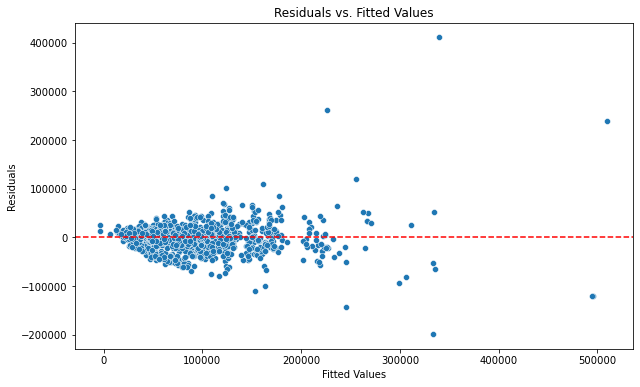

In [171]:
# Assume 'model' is your fitted OLS model
ols_fitted_values = ols_model.fittedvalues
ols_residuals = ols_model.resid

plt.figure(figsize=(10, 6))
sns.scatterplot(x=ols_fitted_values, y=ols_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# train and test for statsmodel

In [187]:
new_xTrain = xTrain
new_yTrain = yTrain
new_Tw = Train_weight
new_xValid = xValid
new_yValid = yValid
new_Vw = Validation_weight

In [203]:
# Assuming xTrain and yTrain are your independent and dependent variables
new_xTrain = sm.add_constant(new_xTrain)  # Adds a constant term to the predictors

# Train OLS model on training data
ols_model1 = sm.OLS(new_yTrain, new_xTrain).fit()

# # Calculate residuals
# residuals = ols_model.resid

# # Calculate variance of residuals
# residual_variance = residuals.var()

/Users/ifeanyichukwumichaelifiegbu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [205]:
new_xValid = sm.add_constant(new_xValid)

In [206]:
y_pred = ols_model1.predict(new_xValid)

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [210]:
# Evaluating the model
mse = mean_squared_error(new_yValid, y_pred)
r2 = r2_score(new_yValid, y_pred)

print(f"Model Coefficients: \n{ols_model1.params}")

Model Coefficients: 
const                                     162637.545508
job_experience                               465.715984
gender_Male                                 1479.548352
job_pay_level_Director II                 144510.040888
job_pay_level_Entry Level                -172937.104012
job_pay_level_Junior Associate           -158606.724490
job_pay_level_Manager                    -109520.133054
job_pay_level_Manger II                   -89876.367168
job_pay_level_Partner                     -30083.770799
job_pay_level_Second Year Associate      -166951.835895
job_pay_level_Senior Associate           -150264.514849
job_pay_level_Sr Manager                  -56822.781310
job_pay_level_Team Lead                  -135052.000800
job_pay_level_VP                          320166.433995
full_or_part_time_Part time               -15604.982675
hourly_or_salary_Salary                    -1356.089910
job_family_group_Client Strategy           12563.802132
job_family_group_Client Tec

In [211]:
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 841988109.7807099


In [212]:
print(f"R-squared: {r2}")


R-squared: 0.7470848307733345


In [213]:
# You can also print a summary of the model
print(ols_model1.summary())

                                 OLS Regression Results                                
Dep. Variable:     annual_salary_amount_in_usd   R-squared:                       0.839
Model:                                     OLS   Adj. R-squared:                  0.834
Method:                          Least Squares   F-statistic:                     170.9
Date:                         Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                                 15:53:12   Log-Likelihood:                -13148.
No. Observations:                         1152   AIC:                         2.637e+04
Df Residuals:                             1117   BIC:                         2.654e+04
Df Model:                                   34                                         
Covariance Type:                     nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------